# Investigation the artifact effect of Tor's note

In this document, we try to understand that why profile B in Tor's note do not feel exhibite boundary artifact. For EM scheme, We will use the function : $$f(Z, dt):==\frac{-(Z + Drift(Z)dt)}{Diffu(Z)}=dW $$ to find the maxmium dW to reach the boundary for Z near the boundary. And then, we will compare the probability density function of dW ~ N(0, dt) to see how like get the maximum dW or less (Remember that dW is negative).

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

## Diffusivity profile

In [2]:
import sympy
z = sympy.symbols('z')
K0 = 0.00019148936170212765
K1 = 6e-3# m / s
Aalpha = 0.5
c=20
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)


## Lgrangian schemes

In [3]:
#######
#Euler#
#######
def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    return temp

########
#Visser#
########
def step_v(z,H,dt,N_sample):
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    a=dKdz(z)
    G=Diffu(z+a*dt/2)
    
    temp= z + a*dt + np.sqrt(2/r*dt*G)*dW
    return temp

def step_v_const(z,H,dt,N_sample):
    K0=3e-3
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    temp= z + np.sqrt(2/r*dt*K0)*dW
    return temp

##############
#Milstein 1nd#
##############
def step_m(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z + (1/2)*dKdz(z)*(dW*dW+dt) + Beta(z)*dW
    return temp

##############
#Milstein 2nd#
##############
def step_m2(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    ddkdz=dAdz(z)
    dddkdz=ddAdzz(z)
    sqrt2k=np.sqrt(2*k)
    
    a=dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
    
    return temp

def step_m2_const(z,H,dt,N_sample):
    K0=3e-3
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z +np.sqrt(2*K0)*dW
    return temp

In [4]:
def oneStep(Z, scheme,H, dt):
    z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    return Z

## Parallel functions

In [8]:
def parallelWiener(Tmax, dt, H, Testdepth, Np, Nbins,
                     queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const):
    np.random.seed()
    Ntime   =int(Tmax/dt)  

    hist_E      =np.zeros((Nbins-1,),'i')
    hist_V      =np.zeros((Nbins-1,),'i')
    hist_M      =np.zeros((Nbins-1,),'i')
    hist_M2     =np.zeros((Nbins-1,),'i')
    hist_EConst =np.zeros((Nbins-1,),'i')
    hist_VConst =np.zeros((Nbins-1,),'i')
    hist_MConst =np.zeros((Nbins-1,),'i')

    zEul    =np.random.uniform(0,H,int(Np))
    zVis    =np.random.uniform(0,H,int(Np))
    zMil    =np.random.uniform(0,H,int(Np))
    zMil2   =np.random.uniform(0,H,int(Np))
    zEulCon =np.random.uniform(0,H,int(Np))
    zVisCon =np.random.uniform(0,H,int(Np))
    zMilCon =np.random.uniform(0,H,int(Np))

    for i in range(Ntime):

        zEul = oneStep( zEul,    step_e,         H, dt)
        zVis = oneStep( zVis,    step_v,         H, dt)
        zMil = oneStep( zMil,    step_m,         H, dt)
        zMil2 = oneStep( zMil2,   step_m2,        H, dt)
        zEulCon = oneStep( zEulCon, step_e_const,   H, dt)
        zVisCon = oneStep( zVisCon, step_v_const,   H, dt)
        zMilCon = oneStep( zMilCon, step_m2_const,  H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(zEul, bins = np.linspace(0, Testdepth, Nbins))
        hist_E=hist_E + temp0

        temp1, _ = np.histogram(zVis, bins = np.linspace(0, Testdepth, Nbins))
        hist_V=hist_V + temp1

        temp2, _ = np.histogram(zMil, bins = np.linspace(0, Testdepth, Nbins))
        hist_M=hist_M + temp2

        temp3, _ = np.histogram(zMil2, bins = np.linspace(0, Testdepth, Nbins))
        hist_M2=hist_M2 + temp3

        ### Constant potensial
        temp4, _ = np.histogram(zEulCon, bins = np.linspace(0, Testdepth, Nbins))
        hist_EConst=hist_EConst + temp4

        temp5, _ = np.histogram(zVisCon, bins = np.linspace(0, Testdepth, Nbins))
        hist_VConst=hist_VConst + temp5

        temp6, _ = np.histogram(zMilCon, bins = np.linspace(0, Testdepth, Nbins))
        hist_MConst=hist_MConst + temp6

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    queneEu.put(hist_E)
    queneEuConst.put(hist_EConst)
    queneV.put(hist_V)
    queneVConst.put(hist_VConst)
    queneM.put(hist_M)
    queneM2.put(hist_M2)
    queneM2Const.put(hist_MConst)
    return None
        
def RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter=Ntime

    if (__name__ == '__main__'):
        threads=[]
        queneEu=      mp.Queue()
        queneEuConst= mp.Queue()
        queneV=       mp.Queue()
        queneVConst=  mp.Queue()
        queneM=       mp.Queue()
        queneM2=      mp.Queue()
        queneM2Const= mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallelWiener, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const))
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_E      = np.zeros((Nbins-1,),'i')
    hist_EConst = np.zeros((Nbins-1,),'i')
    hist_V      = np.zeros((Nbins-1,),'i')
    hist_VConst = np.zeros((Nbins-1,),'i')
    hist_M      = np.zeros((Nbins-1,),'i')
    hist_M2     = np.zeros((Nbins-1,),'i')
    hist_MConst = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_E      += queneEu.get()
        hist_EConst += queneEuConst.get()
        hist_V      += queneV.get()
        hist_VConst += queneVConst.get()
        hist_M      += queneM.get()
        hist_M2     += queneM2.get()
        hist_MConst += queneM2Const.get()

    hist_E  = hist_E  / counter
    hist_V  = hist_V  / counter
    hist_M  = hist_M  / counter
    hist_M2 = hist_M2 / counter
    hist_EConst = hist_EConst / counter
    hist_VConst = hist_VConst / counter
    hist_MConst = hist_MConst / counter

    hist_E  = hist_E  / np.mean(hist_E)
    hist_V  = hist_V  / np.mean(hist_V)
    hist_M  = hist_M  / np.mean(hist_M)
    hist_M2 = hist_M2 / np.mean(hist_M2)
    hist_EConst  = hist_EConst / np.mean(hist_EConst)
    hist_VConst  = hist_VConst / np.mean(hist_VConst)
    hist_MConst  = hist_MConst / np.mean(hist_MConst)
    
    lists=[]
    lists.append(hist_E)
    lists.append(hist_V)
    lists.append(hist_M)
    lists.append(hist_M2)
    lists.append(hist_EConst)
    lists.append(hist_VConst)
    lists.append(hist_MConst)
    
    return lists

## Let's try the diffusivity of K(0) = 0

In [10]:
import sympy
z = sympy.symbols('z')
K0 = 0
K1 = 5e-3# m / s
Aalpha = 0.5
w=0
sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)
Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz =  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)

In [11]:
Np        = 400000
Nbins     = 100
Tmax      = 2*3600          #Maximum time
dt        = 10            #Delta time
H         = 10
Testdepth = 0.2
NumberOfThread = 4

startTime=time()
lists = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins)
endTime=time()
print("Time elapsed: ", endTime-startTime)

hist_E      = lists[0]
hist_V      = lists[1]
hist_M      = lists[2]
hist_M2     = lists[3]
hist_EConst = lists[4]
hist_VConst = lists[5]
hist_MConst = lists[6]

Total number of process:  4
Time elapsed:  118.84748673439026


The f(1e-3) is :  -50.09625257815534


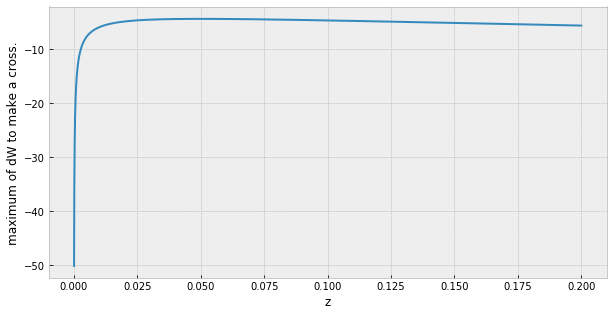

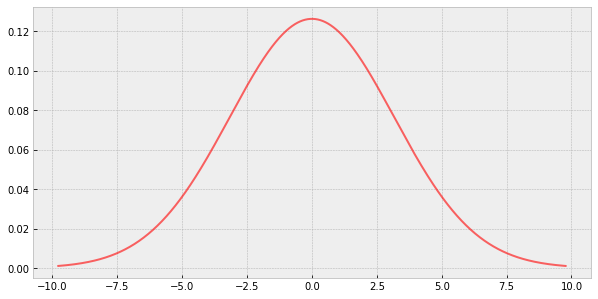

In [13]:
# For Euler scheme.
z = np.linspace(1e-4, 0.2, 10000)
A = Alpha(z)*dt
B = Beta(z)
f = -(z + A)/B

plt.figure(1, figsize = (10, 5))
plt.plot(z, -(z + A)/B)
plt.xlabel("z")
plt.ylabel("maximum of dW to make a cross.")

fig, ax = plt.subplots(1, 1, figsize = (10, 5))

x = np.linspace(norm.ppf(0.001, 0, np.sqrt(dt)), norm.ppf(0.999, 0, np.sqrt(dt)), 1000)
ax.plot(x, norm.pdf(x, 0 , np.sqrt(dt)),
       'r-', lw=2, alpha=0.6, label='norm pdf')
print("The f(1e-3) is : ", f[0])

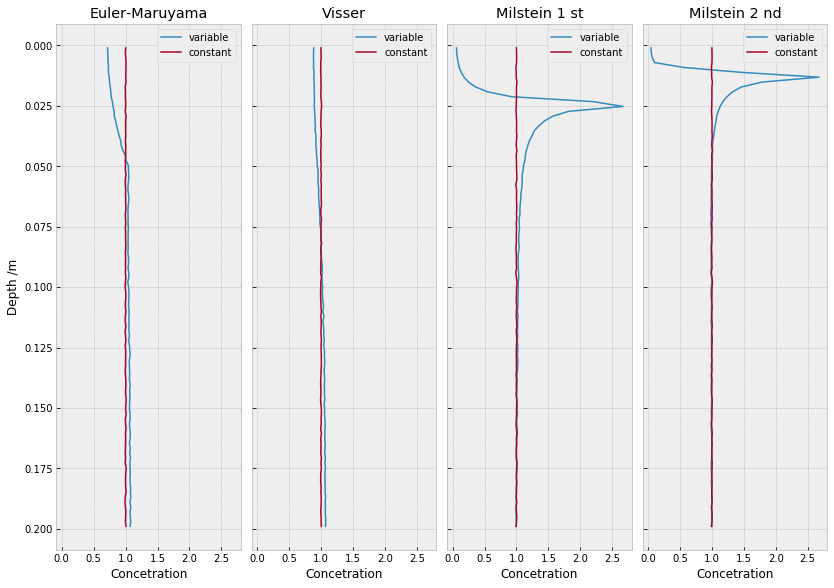

In [14]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27), sharey = True, sharex = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(hist_E, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(hist_EConst, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(hist_V, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(hist_VConst, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('Visser')
ax[1].legend()

ax[2].plot(hist_M, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(hist_MConst, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('Milstein 1 st')
ax[2].legend()

ax[3].plot(hist_M2, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(hist_MConst, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('Milstein 2 nd')
#ax[3].set_xlim(0.8, 1.2)
ax[3].legend()

plt.tight_layout()

## Now, we test the diffusivity of $K_0 = 0.001$

In [6]:
import sympy
z = sympy.symbols('z')
K0 = 0.00019148936170212765
K1 = 6e-3# m / s
Aalpha = 0.5
w=0
sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)
Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta, np)

In [27]:
Np        = 20000
Nbins     = 100
Tmax      = 10*3600          #Maximum time
dt        = 10            #Delta time
H         = 10
Testdepth = 1
NumberOfThread = 4

startTime=time()
lists = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins)
endTime=time()
print("Time elapsed: ", endTime-startTime)

hist_E      = lists[0]
hist_V      = lists[1]
hist_M      = lists[2]
hist_M2     = lists[3]
hist_EConst = lists[4]
hist_VConst = lists[5]
hist_MConst = lists[6]

Total number of process:  4
Time elapsed:  28.502221822738647


The f(0) is :  -5.965081161533159


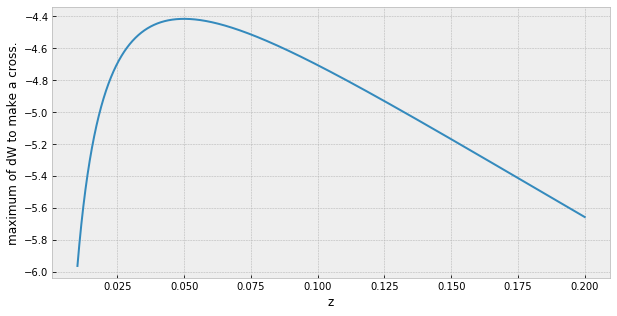

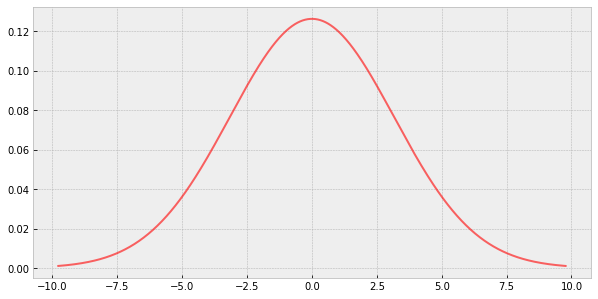

In [24]:
# For Euler scheme.
z = np.linspace(1e-2, 0.2, 10000)
A = Alpha(z)*dt
B = Beta(z)
f = -(z + A)/B

plt.figure(1, figsize = (10, 5))
plt.plot(z, -(z + A)/B)
plt.xlabel("z")
plt.ylabel("maximum of dW to make a cross.")

fig, ax = plt.subplots(1, 1, figsize = (10, 5))

x = np.linspace(norm.ppf(0.001, 0, np.sqrt(dt)), norm.ppf(0.999, 0, np.sqrt(dt)), 1000)
ax.plot(x, norm.pdf(x, 0 , np.sqrt(dt)),
       'r-', lw=2, alpha=0.6, label='norm pdf')
print("The f(0) is : ", f[0])

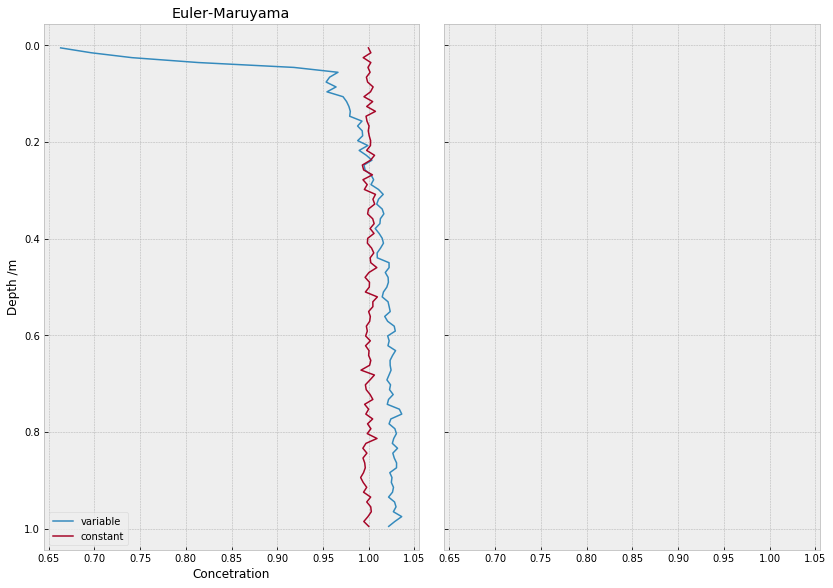

In [25]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 2, figsize = (11.69,8.27), sharey = True, sharex = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(hist_E, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(hist_EConst, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()
ax[0].legend()

#ax[1].plot(hist_V, midpoints, linewidth=1.5, label= "variable")
#ax[1].plot(hist_VConst, midpoints, linewidth=1.5, label= "constant")
#ax[1].set_xlabel('Concetration')
#ax[1].set_title('Visser')
#ax[1].legend()

#ax[2].plot(hist_M, midpoints, linewidth=1.5, label= "variable")
#ax[2].plot(hist_MConst, midpoints, linewidth=1.5, label= "constant")
#ax[2].set_xlabel('Concetration')
#ax[2].set_title('Milstein 1 st')
#ax[2].legend()

#ax[3].plot(hist_M2, midpoints, linewidth=1.5, label= "variable")
#ax[3].plot(hist_MConst, midpoints, linewidth=1.5, label= "constant")
#ax[3].set_xlabel('Concetration')
#ax[3].set_title('Milstein 2 nd')
#ax[3].set_xlim(0.5, 1.5)
#ax[3].legend()

plt.tight_layout()

## Result

It seems that the function $f(Z,dt)$ is a good indicator that the boundary effect will be caused, or not.

# To verify the idea. We try to do the statistic sampling of position of the particle that have chance to utilise the reflection algorithm.

In [7]:
import sympy
z = sympy.symbols('z')
dt = sympy.symbols('dt')
K0 = 0.00019148936170212765
K1 = 6e-3# m / s
Aalpha = 0.5
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)
sym_F = -(z + sym_Alpha*dt)/sym_Beta
sym_dFdz = sympy.diff(sym_F, z, 1)
sym_F_const = -(z)/sympy.sqrt(2*3e-3)
sym_dFdz_const = sympy.diff(sym_F_const, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)
F = sympy.utilities.lambdify([z, dt], sym_F,np)
dFdz = sympy.utilities.lambdify([z, dt], sym_dFdz,np)
F_const = sympy.utilities.lambdify([z, dt], sym_F_const,np)
dFdz_const = sympy.utilities.lambdify([z, dt], sym_dFdz_const,np)
del z, dt

#######
#Euler#
#######
def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    return temp

In [8]:
def oneStep1(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z))
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel1(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand, scheme):
    
    np.random.seed()
    Ntime   =int(Tmax/dt)

    hist_ = np.zeros((Nbins-1,),'i')
    hist_Cross = np.zeros((Nbins-1,),'i')
    hist_Land = np.zeros((Nbins-1,),'i')

    z = np.random.uniform(0 , H, int(Np))

    for i in range(Ntime):

        z, Cross, Land = oneStep1( z,    scheme,         H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins = np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0
        
        temp2, _ = np.histogram(Cross, bins = np.linspace(0, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2
        
        temp3, _ = np.histogram(Land, bins = np.linspace(0, Testdepth, Nbins))
        hist_Land = hist_Land + temp3 

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)
    
    return None
        
def RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):
        
        threads=[]
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallel1, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       quene, queneCross,
                                       queneLand, scheme))
            
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_  = np.zeros((Nbins-1,),'i')
    hist_Cross  = np.zeros((Nbins-1,),'i')
    hist_Land   = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_      += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

    hist_  = hist_  / counter
    hist_  = hist_  / (np.mean(hist_)) # Choose the sum is 2.
    
    hist_Cross = hist_Cross / (np.sum(hist_Cross)*(midpoints[1]-midpoints[0]))
    hist_Land = hist_Land / (np.sum(hist_Land)*(midpoints[1]-midpoints[0]))
    
    return hist_, hist_Cross, hist_Land

In [9]:
Np        = 240000
Nbins     = 200
dt        = 10
Tmax = dt*1*3600
H         = 10
Testdepth = 0.7
NumberOfThread = 4

startTime=time()
E1, E1_Cross, E1_Land = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)
endTime=time()
print("Time elapsed: ", endTime-startTime)

startTime=time()
E1_Const, E1_Const_Cross, E1_Const_Land = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e_const)
endTime=time()
print("Time elapsed: ", endTime-startTime)

Total number of process:  4
Time elapsed:  95.64124202728271
Total number of process:  4
Time elapsed:  38.60636758804321


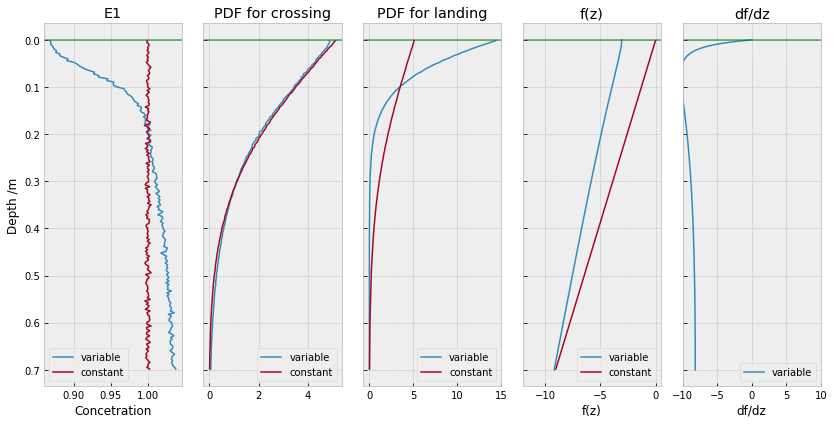

In [17]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 5, figsize = (11.69,6), sharey = True)
ax[0].plot(E1, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_Const, midpoints, linewidth=1.5, label= "constant")
ax[0].axhline(0, color="g", lw=2, alpha = 0.5)
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(E1_Cross, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(E1_Const_Cross, midpoints, linewidth=1.5, label= "constant")
ax[1].axhline(0, color="g", lw=2, alpha = 0.5)
ax[1].set_xlabel("")
ax[1].set_title("PDF for crossing")
ax[1].legend()

ax[2].plot(E1_Land, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_Const_Land, midpoints, linewidth=1.5, label= "constant")
ax[2].axhline(0, color="g", lw=2, alpha = 0.5)
ax[2].set_xlabel("")
ax[2].set_title("PDF for landing")
ax[2].legend()

ax[3].plot(F(bins,dt), bins, linewidth=1.5, label= "variable")
ax[3].plot(F_const(midpoints,dt), midpoints, linewidth=1.5, label= "constant")
ax[3].axhline(0, color="g", lw=2, alpha = 0.5)
ax[3].set_xlabel("f(z)")
ax[3].set_title("f(z)")
ax[3].set_xlim(-12, 0.5)
ax[3].legend()

ax[4].plot(dFdz(bins,dt), bins, linewidth=1.5, label= "variable")
ax[4].axhline(0, color="g", lw=2, alpha = 0.5)
ax[4].set_xlabel('df/dz')
ax[4].set_title("df/dz")
ax[4].set_xlim(-10, 10)
ax[4].legend()

plt.tight_layout()

In [11]:
dFdz(0,dt)

4.263256414560601e-14

In [14]:
dFdz(midpoints,dt)

array([ -1.30306843,  -3.37009308,  -4.90971859,  -6.07789312,
        -6.97739347,  -7.67818182,  -8.22920312,  -8.66550971,
        -9.01271808,  -9.28988285,  -9.51139984,  -9.68829608,
        -9.82912258,  -9.94058367, -10.02798811, -10.09557741,
       -10.14676798, -10.18433197, -10.21053398, -10.22723535,
       -10.23597457, -10.23802982, -10.23446804, -10.22618368,
       -10.21392953, -10.19834145, -10.1799583 , -10.15923813,
       -10.13657129, -10.11229132, -10.08668379, -10.05999367,
       -10.03243149, -10.0041784 ,  -9.97539047,  -9.94620229,
        -9.91672999,  -9.88707383,  -9.85732036,  -9.82754429,
        -9.79781005,  -9.7681732 ,  -9.73868155,  -9.70937618,
        -9.68029229,  -9.65145999,  -9.62290489,  -9.5946487 ,
        -9.56670971,  -9.53910323,  -9.51184191,  -9.48493613,
        -9.45839425,  -9.43222284,  -9.40642693,  -9.38101022,
        -9.35597519,  -9.33132327,  -9.30705501,  -9.28317015,
        -9.25966774,  -9.2365462 ,  -9.21380347,  -9.19

In [15]:
midpoints

array([0.00175879, 0.00527638, 0.00879397, 0.01231156, 0.01582915,
       0.01934673, 0.02286432, 0.02638191, 0.0298995 , 0.03341709,
       0.03693467, 0.04045226, 0.04396985, 0.04748744, 0.05100503,
       0.05452261, 0.0580402 , 0.06155779, 0.06507538, 0.06859296,
       0.07211055, 0.07562814, 0.07914573, 0.08266332, 0.0861809 ,
       0.08969849, 0.09321608, 0.09673367, 0.10025126, 0.10376884,
       0.10728643, 0.11080402, 0.11432161, 0.1178392 , 0.12135678,
       0.12487437, 0.12839196, 0.13190955, 0.13542714, 0.13894472,
       0.14246231, 0.1459799 , 0.14949749, 0.15301508, 0.15653266,
       0.16005025, 0.16356784, 0.16708543, 0.17060302, 0.1741206 ,
       0.17763819, 0.18115578, 0.18467337, 0.18819095, 0.19170854,
       0.19522613, 0.19874372, 0.20226131, 0.20577889, 0.20929648,
       0.21281407, 0.21633166, 0.21984925, 0.22336683, 0.22688442,
       0.23040201, 0.2339196 , 0.23743719, 0.24095477, 0.24447236,
       0.24798995, 0.25150754, 0.25502513, 0.25854271, 0.26206

In [169]:
F(0.05959, 10)

-4.400231172284653

In [132]:
norm.ppf(0.341, 0, np.sqrt(dt))

-1.295697355998348

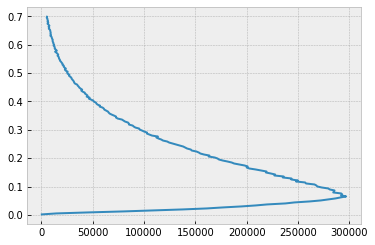

In [304]:
z = np.random.choice(E1_Cross.size, 20000000, p=np.ndarray.tolist(E1_Cross/np.sum(E1_Cross)))
temp, _ = np.histogram(midpoints[z], bins = np.linspace(0, 0.7, 200))
plt.plot(temp, midpoints)


In [275]:
np.random.choice(5, 3, p=[0.1, 0, 0.3, 0.6, 0])

array([0, 2, 2])